In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0-rc3
Eager mode:  True
GPU is available


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('/content/covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content/covid19-ct-scans')

In [3]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
14,/content/covid19-ct-scans/ct_scans/radiopaedia...,/content/covid19-ct-scans/lung_mask/radiopaedi...,/content/covid19-ct-scans/infection_mask/radio...,/content/covid19-ct-scans/lung_and_infection_m...
10,/content/covid19-ct-scans/ct_scans/radiopaedia...,/content/covid19-ct-scans/lung_mask/radiopaedi...,/content/covid19-ct-scans/infection_mask/radio...,/content/covid19-ct-scans/lung_and_infection_m...
12,/content/covid19-ct-scans/ct_scans/radiopaedia...,/content/covid19-ct-scans/lung_mask/radiopaedi...,/content/covid19-ct-scans/infection_mask/radio...,/content/covid19-ct-scans/lung_and_infection_m...
6,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
8,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [0]:
Height = 224
Width = 224

def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

@tf.function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (Height, Width))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (Height, Width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.image.grayscale_to_rgb(input_image)
    input_image = tf.image.per_image_standardization(input_image)
    return input_image, input_mask

In [5]:
num_of_files = len(raw_data)
train_test_split = 0.3
for idx in range(num_of_files):
    raw_image = read_nii(raw_data.loc[idx,'ct_scan'])
    raw_mask  = read_nii(raw_data.loc[idx,'lung_and_infection_mask'])
    slices = raw_image.shape[2]
    raw_image = raw_image[:,:,round(slices*0.2):round(slices*0.8)]
    raw_mask = raw_mask[:,:,round(slices*0.2):round(slices*0.8)]
    raw_image = np.reshape(np.rollaxis(raw_image, 2),(raw_image.shape[2],raw_image.shape[0],raw_image.shape[1],1))
    raw_mask = np.reshape(np.rollaxis(raw_mask, 2),(raw_mask.shape[2],raw_mask.shape[0],raw_mask.shape[1],1))
    print(raw_image.shape,raw_mask.shape)
    raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
    raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)

    temp = tf.data.Dataset.from_tensor_slices({'image':raw_image,'segmentation_mask':raw_mask})

    if idx == 0:
        dataset = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.concatenate(temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE))

print(dataset.element_spec)

TOTAL_LENGTH = tf.data.experimental.cardinality(dataset).numpy()

dataset = dataset.shuffle(TOTAL_LENGTH)
test_dataset = dataset.take(round(train_test_split*TOTAL_LENGTH))
train_dataset = dataset.skip(round(train_test_split*TOTAL_LENGTH))

TEST_LENGTH = round(train_test_split*TOTAL_LENGTH)
TRAIN_LENGTH = TOTAL_LENGTH - TEST_LENGTH
BATCH_SIZE = 16
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset_batched = train_dataset.cache().batch(BATCH_SIZE).repeat()
train_dataset_batched = train_dataset_batched.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset_batched = test_dataset.batch(BATCH_SIZE)
print(TRAIN_LENGTH, TEST_LENGTH)

(181, 512, 512, 1) (181, 512, 512, 1)
(120, 512, 512, 1) (120, 512, 512, 1)
(120, 512, 512, 1) (120, 512, 512, 1)
(162, 512, 512, 1) (162, 512, 512, 1)
(174, 512, 512, 1) (174, 512, 512, 1)
(127, 512, 512, 1) (127, 512, 512, 1)
(149, 512, 512, 1) (149, 512, 512, 1)
(181, 512, 512, 1) (181, 512, 512, 1)
(154, 512, 512, 1) (154, 512, 512, 1)
(181, 512, 512, 1) (181, 512, 512, 1)
(23, 630, 630, 1) (23, 630, 630, 1)
(250, 630, 630, 1) (250, 630, 630, 1)
(66, 401, 630, 1) (66, 401, 630, 1)
(40, 630, 630, 1) (40, 630, 630, 1)
(26, 630, 630, 1) (26, 630, 630, 1)
(26, 630, 630, 1) (26, 630, 630, 1)
(27, 630, 630, 1) (27, 630, 630, 1)
(55, 630, 630, 1) (55, 630, 630, 1)
(23, 630, 630, 1) (23, 630, 630, 1)
(27, 630, 630, 1) (27, 630, 630, 1)
(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float64, name=None))
1478.0 634.0


{0.0: 40914, 1.0: 8992, 2.0: 270}


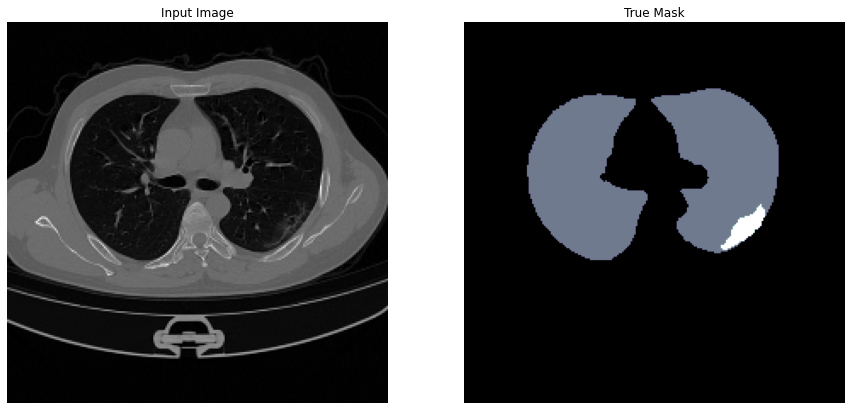

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='bone')
        plt.axis('off')
    plt.show()

for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
    unique, counts = np.unique(sample_mask, return_counts=True)
    print(dict(zip(unique, counts)))
    display([sample_image, sample_mask])

In [0]:
OUTPUT_CHANNELS = 3 #None, Lung, Infestion
base_model = tf.keras.applications.MobileNetV2(input_shape=[Height, Width, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',   
    'block_6_expand_relu',   
    'block_13_expand_relu',  
    'block_16_project',      
]
layers = [base_model.get_layer(name).output for name in layer_names]
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3), 
    pix2pix.upsample(256, 3), 
    pix2pix.upsample(128, 3), 
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[Height, Width, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

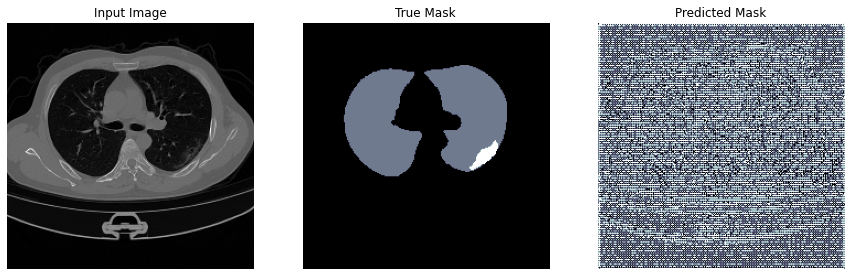

In [11]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

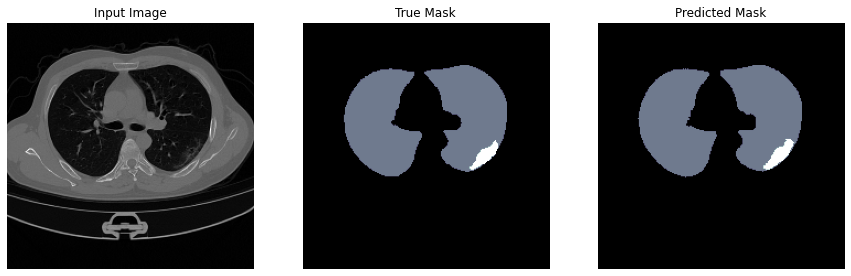


Sample Prediction after epoch 20

92/92 [==============================] - 13s 138ms/step - loss: 0.0123 - accuracy: 0.9951 - val_loss: 0.0199 - val_accuracy: 0.9924


In [13]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset_batched, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset_batched,
                          callbacks=[DisplayCallback()])

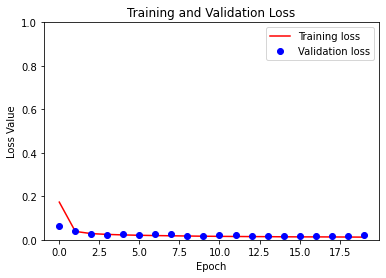

In [14]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

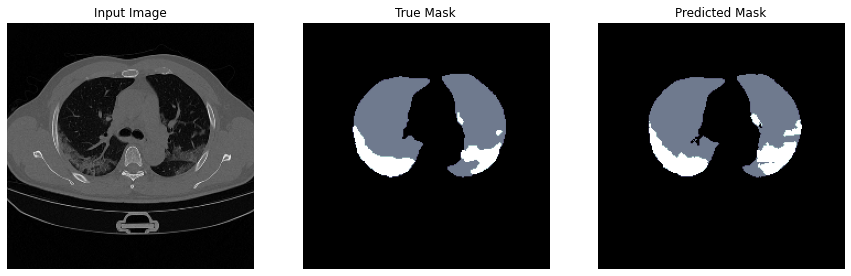

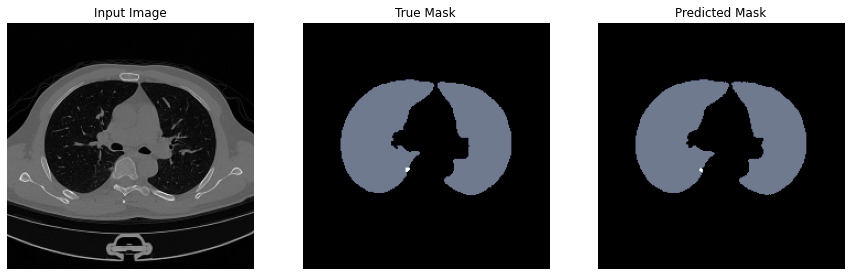

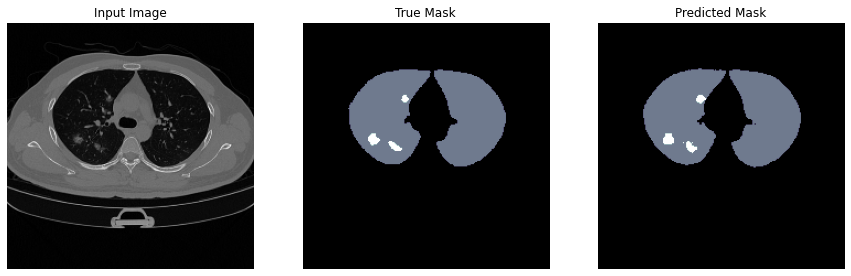

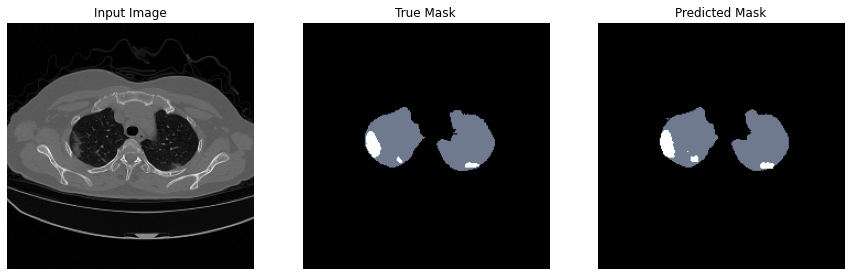

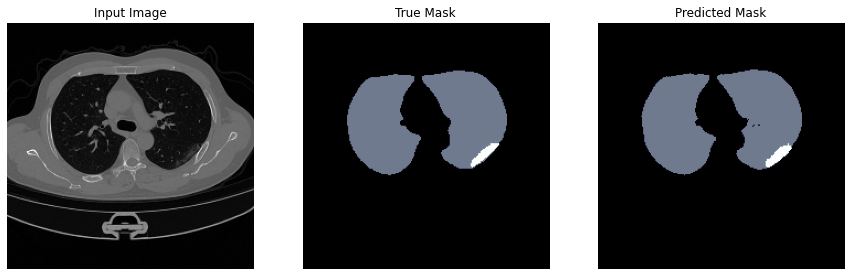

In [15]:
show_predictions(test_dataset_batched, num=5)